In [50]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath


import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

import SimpleTemp
from SimpleTemp import _temperature_scaling
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
import plotter
from plotter import plotter

import Platt
from Platt import PlattCalibrator
sys.path.append(dirname(dirname(realpath(os.getcwd()))))


In [51]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [52]:
logpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.dev_preds")


In [53]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=30)
    return prob_true, prob_pred


In [54]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [55]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [56]:
with open(logpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [57]:
testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [58]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return  1/(1 + np.exp(-p))


In [59]:
y_prob = np.array(M1['probs'])
y_true = np.array(M1['golds'],dtype = int)
p_test = M_test1['probs']

In [60]:
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression

In [61]:
def isotonic (y_prob, y_true, p_test):
    Iso = IsotonicRegression().fit(y_prob.reshape(-1,1), y_true)
    out=Iso.predict (p_test)
    return  out

In [62]:
def platt_global (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0]  + 4.973
    out = 1 / (1 + np.exp(fit))
    return  out

In [64]:
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [65]:
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)


In [66]:
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [67]:
tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)


In [78]:
cal1 =isotonic (logit(mp1),  gold1,  logit(tp1) )
cal2 =isotonic (logit(mp2),  gold2,   logit(tp2) )
cal3 =isotonic (logit(mp3),  gold3,  logit(tp3) )
cal4 =isotonic (logit(mp4),  gold4,  logit(tp4) )
cal0 =isotonic (logit(np.array(M['probs'])), np.array(M ['golds'],dtype = int),  M_test ['probs']  )

(array([1973., 3597.,   80., 2204., 1921., 2990.,  174.,  801.,  143.,
         168.]),
 array([0.        , 0.00540541, 0.01081081, 0.01621622, 0.02162162,
        0.02702703, 0.03243243, 0.03783784, 0.04324324, 0.04864865,
        0.05405405]),
 <BarContainer object of 10 artists>)

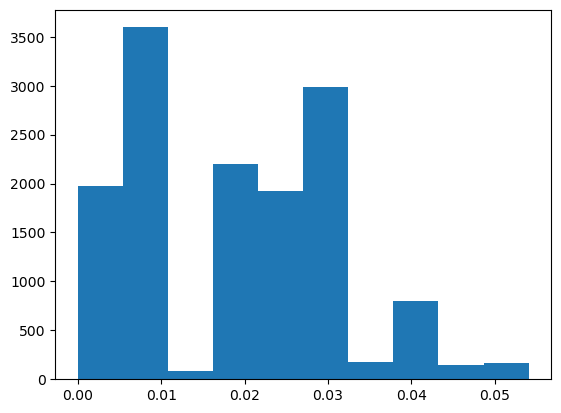

In [79]:
plt.hist(cal2)

In [39]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal4 )


In [267]:
#no calibration
y1, p1 = compute_calibration_curve(M_test1['golds'], tp1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], tp2)
y3, p3 = compute_calibration_curve(M_test3['golds'], tp3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], tp4 )


In [40]:
y0, p0 = compute_calibration_curve(M_test['golds'], cal0 )


In [41]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

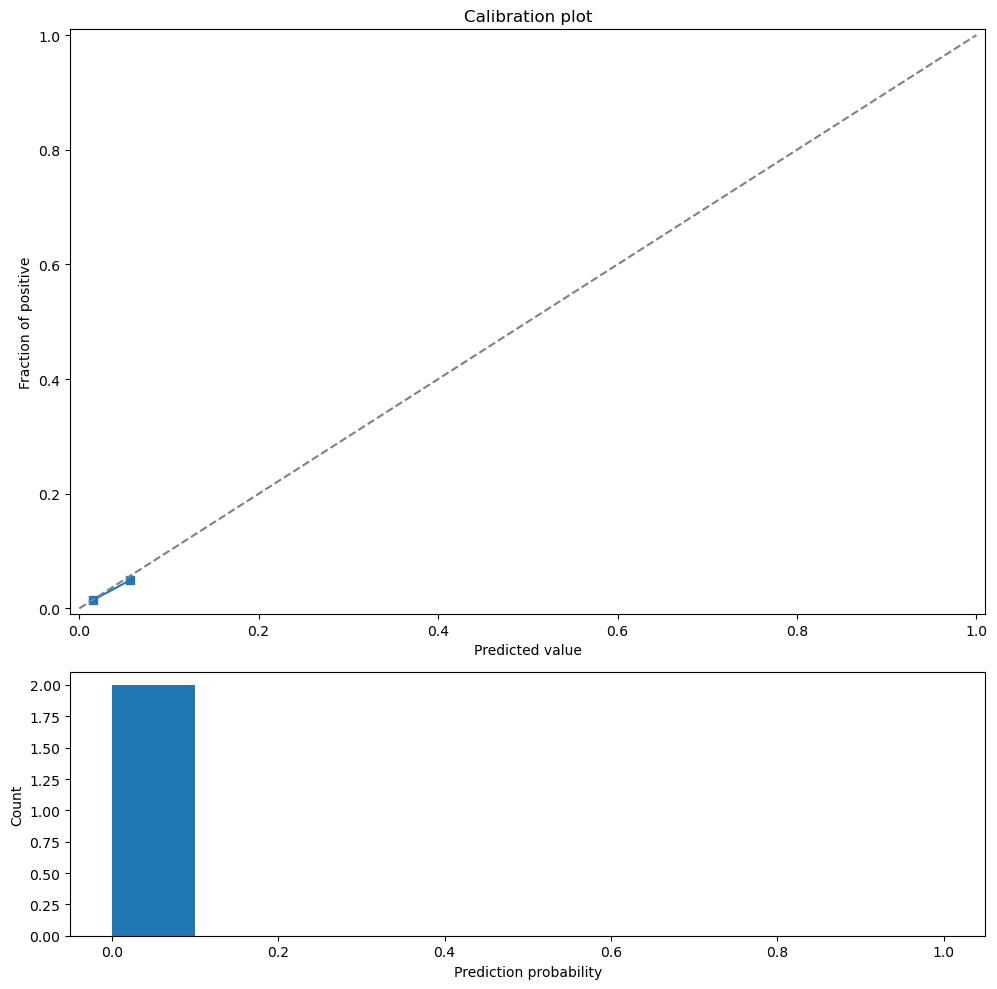

In [45]:
plotter(p0, y0)

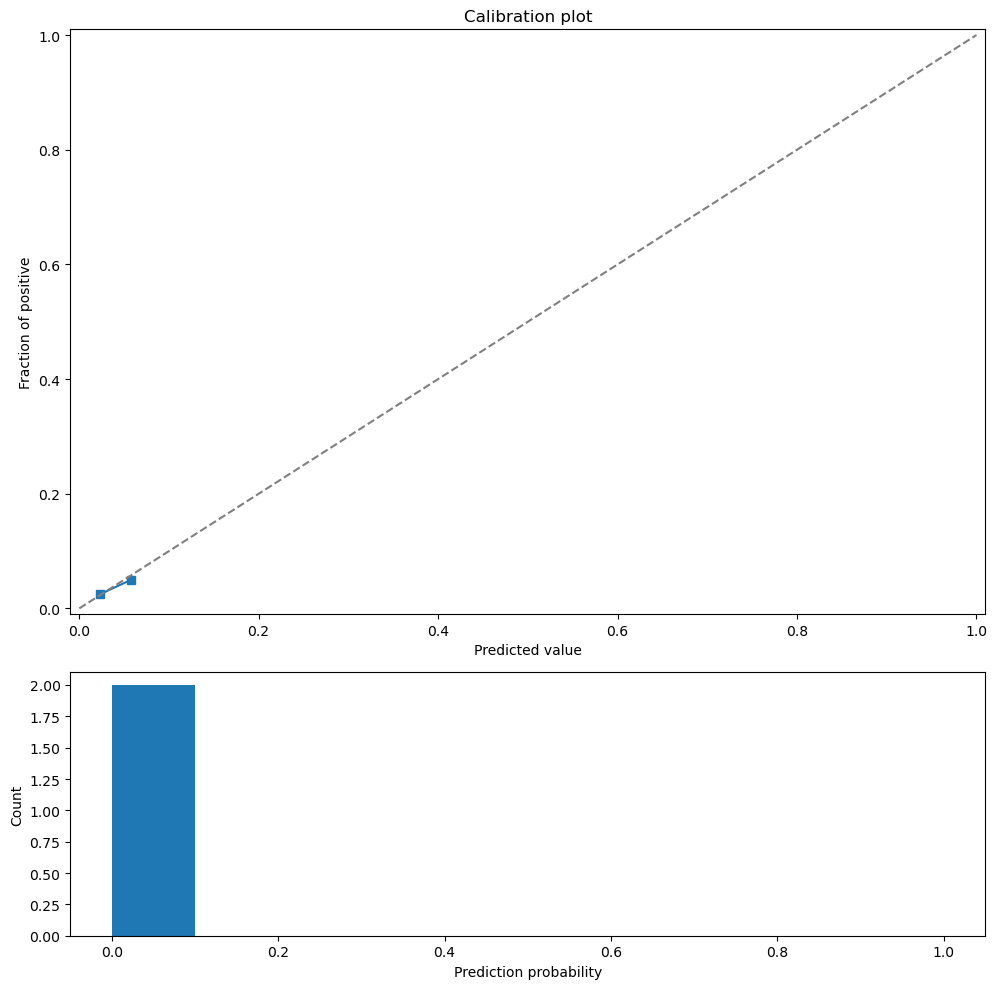

In [46]:
plotter(p1, y1)

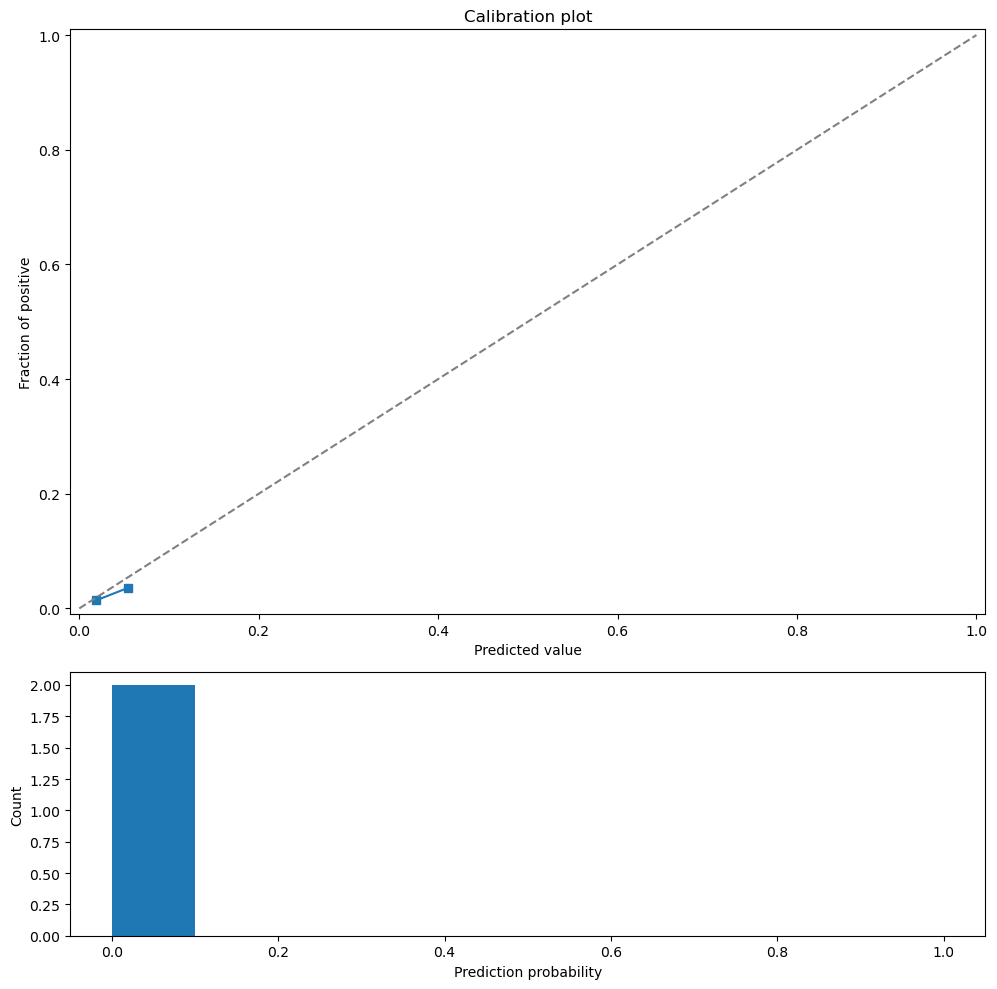

In [47]:
plotter(p2, y2)

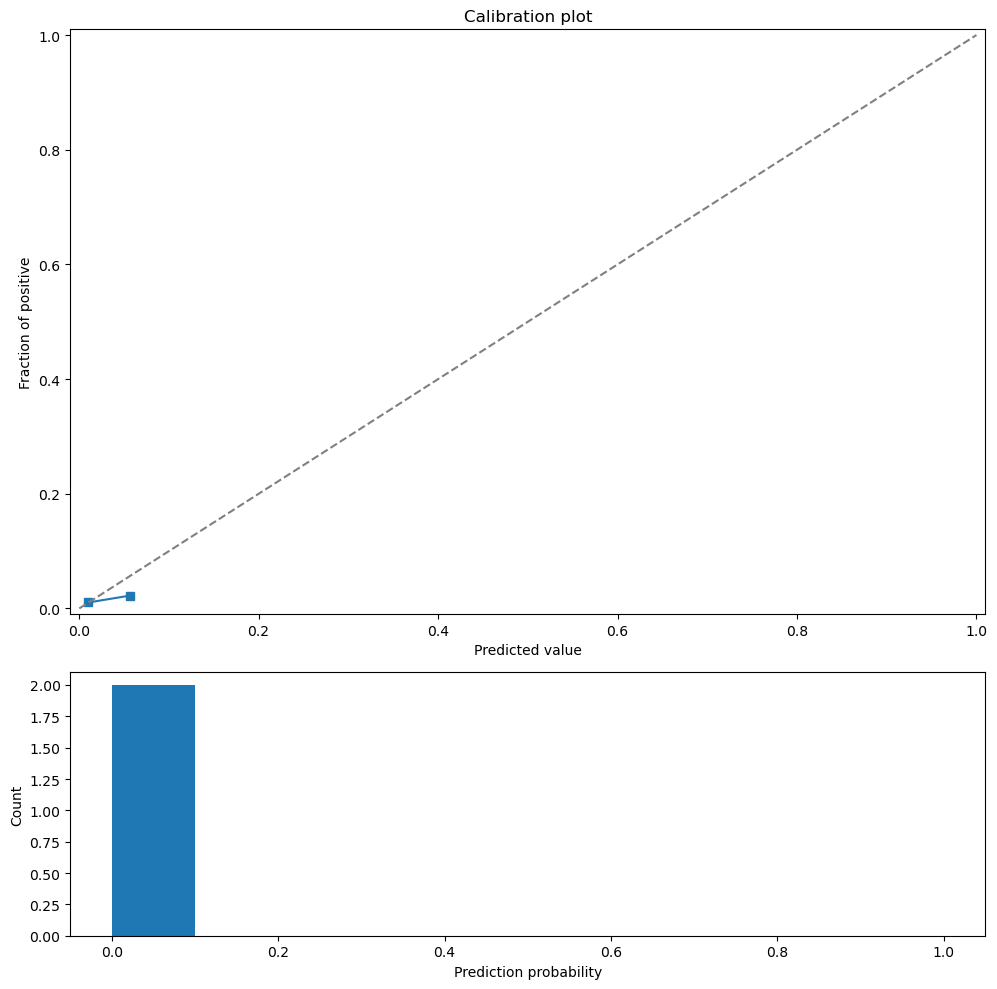

In [48]:
plotter(p3, y3)

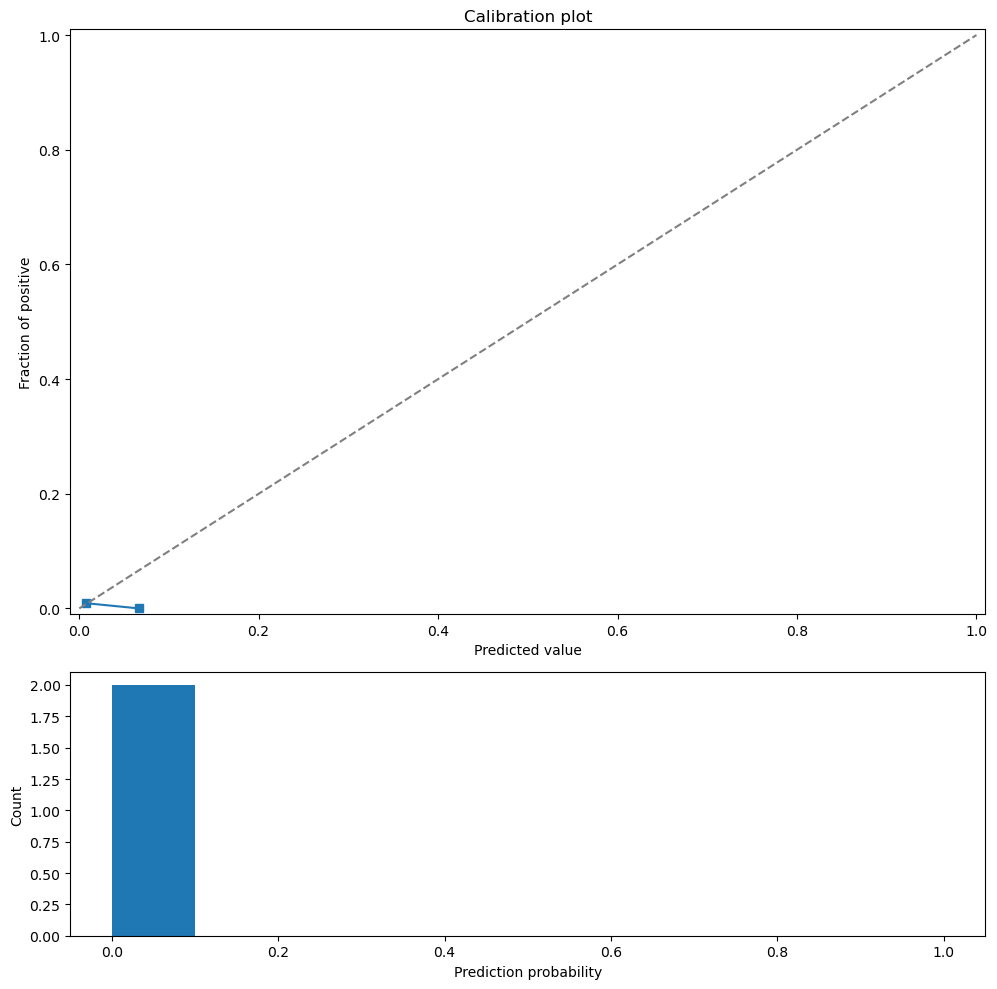

In [49]:
plotter(p4, y4)

(array([2451., 2792., 2698., 2569., 2145., 1737., 1021.,  459.,  146.,
          11.]),
 array([0.01589061, 0.06250444, 0.10911827, 0.1557321 , 0.20234593,
        0.24895976, 0.29557359, 0.34218742, 0.38880124, 0.43541507,
        0.4820289 ]),
 <BarContainer object of 10 artists>)

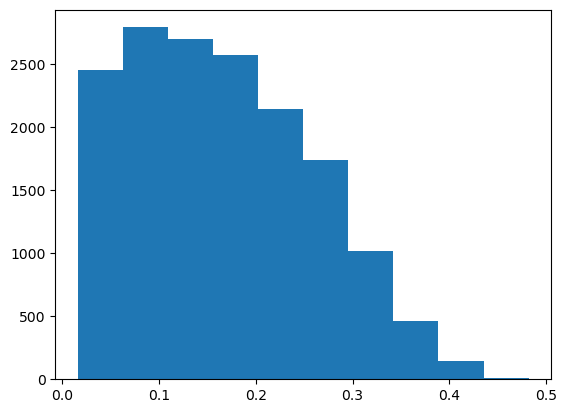

In [53]:
plt.hist( M1['probs'].to_numpy())

In [ ]:
sklearn.metrics.roc_auc_score(m1['outcome'],  m1['p6'], average = 'samples')


0.5600783435183764

In [ ]:
( confusion_matrix (m1['outcome'],  m1['p6']>.5) )

array([[72681,     5],
       [ 4301,     0]], dtype=int64)

In [ ]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])